In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '../..'))

from PySDM.physics import si
from PySDM.initialisation.spectral_sampling import ConstantMultiplicity
from PySDM.initialisation.spectra import Gaussian
from PySDM.physics.formulae import volume

/home/edejong/.conda/envs/edjPySDM/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  warnings.warn(problem)


# 1. Golovin Kernel

98304.0
30251.0


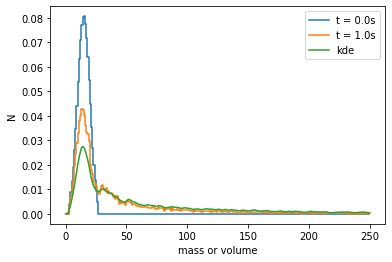

In [23]:
# Set desired constants
K      = 8e-7          # Kernel constant
dt_sim = 1e-3          # time step
T_sim  = 1             # total time of simulation
n_sd   = 2**14         # number of superdroplets
N0     = 1e5           # total number of droplets
end_step = int(T_sim / dt_sim)
mu = 15
sigma = 5
kde_fac = 0.01

# initial distribution
initial_spectrum = Gaussian(norm_factor=N0, loc=15, scale=5)
attributes = {}
attributes['volume'], attributes['n'] =\
    ConstantMultiplicity(spectrum=initial_spectrum).sample(n_sd)

from PySDM import Builder
from PySDM.environments import Box
from PySDM.dynamics import Coalescence
from PySDM.dynamics.coalescence.kernels import Golovin
from PySDM.backends import CPU
from PySDM.products.state import ParticlesVolumeSpectrum, ParticlesNumberVolumeSpectrum, KthMoment

builder = Builder(n_sd=n_sd, backend=CPU)
builder.set_environment(Box(dt=dt_sim, dv=1))
builder.add_dynamic(Coalescence(kernel=Golovin(b = K)))
products = [ParticlesVolumeSpectrum(), ParticlesNumberVolumeSpectrum(), KthMoment()]
particles = builder.build(attributes, products)

from matplotlib import pyplot
import numpy as np

v_bins_edges = np.linspace((1), (250), num=251)

for step in [0, end_step]:
    particles.run(step - particles.n_steps)
    pyplot.step(x=v_bins_edges[:-1],
                y=particles.products['N(v)'].get(v_bins_edges)/particles.products['Mk'].get(0),
                where='post', label=f"t = {step*dt_sim}s")
    print((particles.products['Mk'].get(0)))

## Interpolate it back to a smooth function
from scipy import stats
kde_pts = particles.particles.get_extensive_attrs().to_ndarray()
kde = stats.gaussian_kde(kde_pts[0], kde_fac)

x = np.linspace(0,250,500)
y = kde(x)
pyplot.plot(x ,y, label="kde")

pyplot.xlabel('mass or volume')
pyplot.ylabel("N")
pyplot.legend()

## Distribution comparison:
We have 
- kde(x), the superdroplets
- rbf(x), the collocation method
- mom(x), the original Cloudy MOM

Updated on 11/1/2020 with golovin constants

In [11]:
# import rbf from julia setup
from scipy.stats import norm

def gauss_basis(x, mean, stddev):
    return norm.pdf(x, loc=mean, scale=stddev)

def rbf_basis(x, constants, means, stddev):
    N = len(means)
    assert (len(stddev) == N)
    assert (len(constants) == N)
    pdf_result = 0
    
    for i in range(N):
        pdf_result += constants[i]*gauss_basis(x, means[i], stddev[i])
        
    return pdf_result

def rbf3(x):
    means = [15.0, 47.434164902525694, 149.99999999999997]
    stddev = [5.0, 64.10364693592142, 64.10364693592142]
    c =  [0.455151425107445, 0.2721745063013258, 0.27267406859122917]
    return rbf_basis(x, c, means, stddev)

def rbf6(x):
    means =  [15.0, 25.18134982456162, 42.273358599129985, 70.96668207625552, 119.13578981670909, 199.99999999999994]
    stddev = [5.0, 10.682505484105226, 17.93332717320346, 30.10569233778348, 50.54013136455678, 50.54013136455678]
    c =  [0.2728156119447165, 0.19966352886874714, 0.40327874089359317, -4.576872398182339e-8, -1.2491256101973727e-8, 0.12424217655292323]
    return rbf_basis(x, c, means, stddev)
    
def rbf10(x):
    means =  [15.0, 20.0025079647447, 26.67335499197833, 35.568933044900625, 47.43119110187304, 63.2495185195029, 84.34326653017487, 112.47179070282719, 149.98119262282665, 199.99999999999994]
    stddev = [5.0, 4.169279392021017, 5.559736283076435, 7.413911285607759, 9.886454636018662, 13.183592506669983, 17.580327607907698, 23.443376199999662, 31.261754610733306, 31.261754610733306]
    c =  [0.37175193816576213, 5.2697846253012954e-8, 0.09408962098083347, 0.18320956766246013, -1.207574958194732e-6, 0.16889529273037385, 1.4200187670196495e-7, 0.08020593205636321, -3.1245658630947014e-7, 0.1018489737360288]
    return rbf_basis(x, c, means, stddev)
    

In [12]:
# import cloudy from julia setup
def mom(x):
    mean = 49.88304918927659
    stddev = 81.71672839328512
    return norm.pdf(x, loc=mean, scale=stddev)


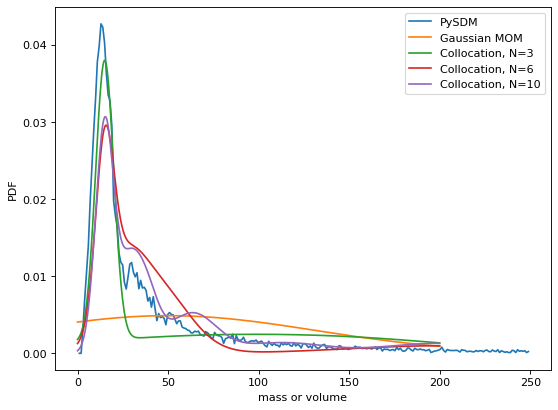

In [31]:
# plot all of them
pyplot.figure(num=None, figsize=(8,6), dpi=80, facecolor='w', edgecolor='k')

x = np.linspace(0,200,500)
x_sdm=v_bins_edges[:-1]
y_sdm=particles.products['N(v)'].get(v_bins_edges)/particles.products['Mk'].get(0)
pyplot.plot(x_sdm, y_sdm, label="PySDM")
#ykde = kde(x)
#pyplot.plot(x ,ykde, label="PySDM kde")
ymom = mom(x)
pyplot.plot(x, ymom, label="Gaussian MOM")
yrbf3 = rbf3(x)
pyplot.plot(x, yrbf3, label="Collocation, N=3")
yrbf6 = rbf6(x)
pyplot.plot(x, yrbf6, label="Collocation, N=6")
yrbf10 = rbf10(x)
pyplot.plot(x, yrbf10, label="Collocation, N=10")

pyplot.xlabel("mass or volume")
pyplot.ylabel("PDF")
pyplot.legend()

In [15]:
# KL Divergence of 2 metrics
from scipy.stats import entropy

def kl_div(qk, pk):
    return entropy(qk, pk)

print("PySDM: ", kl_div(ykde, ykde))
print("MOM: ", kl_div(ykde, ymom))
print("RBF3: ", kl_div(ykde, yrbf3))
print("RBF6: ", kl_div(ykde, yrbf6))
print("RBF10: ", kl_div(ykde, yrbf10))

PySDM:  0.0
MOM:  0.36493642827069994
RBF3:  0.1810442951789857
RBF6:  0.20659917918725285
RBF10:  0.036316030111684924


In [16]:
# KS test

def ks_test(qk, pk):
    dists = abs(qk - pk)
    return max(dists)

print("PySDM: ", ks_test(ykde, ykde))
print("MOM: ", ks_test(ykde, ymom))
print("RBF3: ", ks_test(ykde, yrbf3))
print("RBF6: ", ks_test(ykde, yrbf6))
print("RBF10: ", ks_test(ykde, yrbf10))

PySDM:  0.0
MOM:  0.023137653892828222
RBF3:  0.010403995082757883
RBF6:  0.007590446107773234
RBF10:  0.005980312464791408


In [17]:
# W1 distance (empirical)
from scipy.stats import wasserstein_distance

def w1(qk, pk):
    return wasserstein_distance(qk, pk)

print("PySDM: ", w1(ykde, ykde))
print("MOM: ", w1(ykde, ymom))
print("RBF3: ", w1(ykde, yrbf3))
print("RBF6: ", w1(ykde, yrbf6))
print("RBF10: ", w1(ykde, yrbf10))

PySDM:  0.0
MOM:  0.002572185557444117
RBF3:  0.0017916440352387449
RBF6:  0.0015536310984465348
RBF10:  0.0008024188075113528


## Ouputting Moments
Either the k'th or the first k moments can be output with my defined state products.

In [18]:
# Plot the moments over time
n_time = 100
from PySDM.products.state import KMoments

builder = Builder(n_sd=n_sd, backend=CPU)
builder.set_environment(Box(dt=dt_sim, dv=1))
builder.add_dynamic(Coalescence(kernel=Golovin(b = K)))
products = [KMoments()]
particles = builder.build(attributes, products)

k = 3
tsteps = range(n_time)
Mk = np.zeros((len(tsteps), k))
Mk_norm = np.zeros((len(tsteps), k))

## PySDM solutions
for i, step in enumerate(tsteps):
    step = int(end_step*step/(n_time-1))
    particles.run(step - particles.n_steps)
    Mk[i,:] = (particles.products['M0-Mk'].get(k))
    Mk_norm[i,:] = Mk[i,:] / Mk[0,:]
    
# Analytic solutions
def golovin_M012_norm_analytic(M_0, t, b):
    M0 = M_0[0]*np.exp(-b*M_0[1]*t)
    M1 = M_0[1]
    M2 = M_0[2]*np.exp(2*b*M_0[1]*t)
    return [M0/M_0[0], M1/M_0[1], M2/M_0[2]]

#M_0 = [N0, N0*k*theta, N0*(k+1)*k*theta**2]
mu = 15
sigma = 5
M_0 = [N0, N0*mu, N0*(mu**2 + sigma**2)]
Mk_norm_analytic = np.zeros((len(tsteps), k))
for i, step in enumerate(tsteps):
    t = T_sim*step/(n_time-1)
    Mk_norm_analytic[i,:] = golovin_M012_norm_analytic(M_0,t,K)

initial moments:  [   98304.          1474560.         24265027.43164101]
final moments:  [3.01330000e+04 1.47456000e+06 2.55339887e+08]
initial moments:  [   98304.          1474560.         24265027.43164101]
final moments:  [3.01330000e+04 1.47456000e+06 2.55339887e+08]
initial moments:  [   98304.          1474560.         24265027.43164101]
final moments:  [3.01330000e+04 1.47456000e+06 2.55339887e+08]


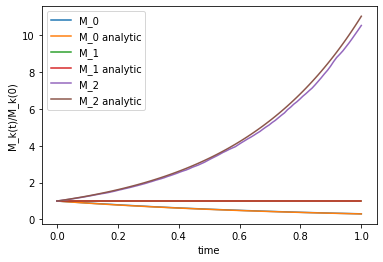

In [25]:
j=0
pyplot.plot([t/(n_time-1)*T_sim for t in tsteps], Mk_norm[:,j], label=f"M_{j}")
pyplot.plot([t/(n_time-1)*T_sim for t in tsteps], Mk_norm_analytic[:,j], label=f"M_{j} analytic")
    
pyplot.xlabel("time")
pyplot.ylabel("M_k(t)/M_k(0)")
pyplot.legend()

print("initial moments: ", Mk[0,:])
print("final moments: ", Mk[-1,:])

j=1
pyplot.plot([t/(n_time-1)*T_sim for t in tsteps], Mk_norm[:,j], label=f"M_{j}")
pyplot.plot([t/(n_time-1)*T_sim for t in tsteps], Mk_norm_analytic[:,j], label=f"M_{j} analytic")
    
pyplot.xlabel("time")
pyplot.ylabel("M_k(t)/M_k(0)")
pyplot.legend()

print("initial moments: ", Mk[0,:])
print("final moments: ", Mk[-1,:])

j=2
pyplot.plot([t/(n_time-1)*T_sim for t in tsteps], Mk_norm[:,j], label=f"M_{j}")
pyplot.plot([t/(n_time-1)*T_sim for t in tsteps], Mk_norm_analytic[:,j], label=f"M_{j} analytic")
    
pyplot.xlabel("time")
pyplot.ylabel("M_k(t)/M_k(0)")
pyplot.legend()

print("initial moments: ", Mk[0,:])
print("final moments: ", Mk[-1,:])

## 2. Initial condition and closure error in RBF and MOM
RBF will still use Gaussian basis functions, and MOM will still use same closure (same as above). But now use a different functional form for the PySDM simulation: gamma sampling. 

98304.0
31031.0


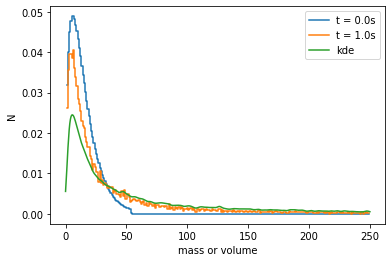

In [33]:
from PySDM.initialisation.spectra import Gamma

# Set desired constants
K      = 8e-7          # Kernel constant
dt_sim = 1e-3          # time step
T_sim  = 1             # total time of simulation
n_sd   = 2**14         # number of superdroplets
N0     = 1e5           # total number of droplets
end_step = int(T_sim / dt_sim)
mu = 15
sigma = 5
k_shape = sigma**2/mu
theta_scale = mu**2/sigma**2
kde_fac = 0.01

# initial distribution
initial_spectrum = Gamma(norm_factor=N0, k=k_shape, theta=theta_scale)
attributes = {}
attributes['volume'], attributes['n'] =\
    ConstantMultiplicity(spectrum=initial_spectrum).sample(n_sd)

from PySDM import Builder
from PySDM.environments import Box
from PySDM.dynamics import Coalescence
from PySDM.dynamics.coalescence.kernels import Golovin
from PySDM.backends import CPU
from PySDM.products.state import ParticlesVolumeSpectrum, ParticlesNumberVolumeSpectrum, KthMoment

builder = Builder(n_sd=n_sd, backend=CPU)
builder.set_environment(Box(dt=dt_sim, dv=1))
builder.add_dynamic(Coalescence(kernel=Golovin(b = K)))
products = [ParticlesVolumeSpectrum(), ParticlesNumberVolumeSpectrum(), KthMoment()]
particles = builder.build(attributes, products)

from matplotlib import pyplot
import numpy as np

v_bins_edges = np.linspace((1), (250), num=251)

for step in [0, end_step]:
    particles.run(step - particles.n_steps)
    pyplot.step(x=v_bins_edges[:-1],
                y=particles.products['N(v)'].get(v_bins_edges)/particles.products['Mk'].get(0),
                where='post', label=f"t = {step*dt_sim}s")
    print((particles.products['Mk'].get(0)))

## Interpolate it back to a smooth function
from scipy import stats
kde_pts = particles.particles.get_extensive_attrs().to_ndarray()
kde = stats.gaussian_kde(kde_pts[0], kde_fac)

x = np.linspace(0,250,500)
y = kde(x)
pyplot.plot(x ,y, label="kde")

pyplot.xlabel('mass or volume')
pyplot.ylabel("N")
pyplot.legend()

In [40]:
# import rbf from julia setup
from scipy.stats import norm
from scipy.stats import gamma

def gauss_basis(x, mean, stddev):
    return norm.pdf(x, loc=mean, scale=stddev)

def rbf_basis(x, constants, means, stddev):
    N = len(means)
    assert (len(stddev) == N)
    assert (len(constants) == N)
    pdf_result = 0
    
    for i in range(N):
        pdf_result += constants[i]*gauss_basis(x, means[i], stddev[i])
        
    return pdf_result

def rbf3(x):
    means = [5.0, 27.386127875258303, 149.99999999999997]
    stddev = [13.991329922036439, 76.63367007796354, 76.63367007796354]
    c =   [0.3329856744274011, 0.6670143283615846, -2.788985798376376e-9]
    return rbf_basis(x, c, means, stddev)

def rbf6(x):
    means =  [5.0, 9.871752429174096, 19.49029920458094, 38.48068170363038, 75.97435261681774, 149.99999999999997]
    stddev = [3.125, 6.011591734629277, 11.8689890619059, 23.433544320742097, 46.26602961448889, 46.26602961448889]
    c =   [0.1250474397786209, 0.16407267025558744, 0.18320428483282786, 0.3689180783337001, -2.771995966708748e-7, 0.15875780399886047]
    return rbf_basis(x, c, means, stddev)
    
def rbf10(x):
    means =  [5.0, 7.296164014805424, 10.64680186618832, 15.536162529769292, 22.67087799557423, 33.08208884307056, 48.27446923028147, 70.44368904636232, 102.79374181804234, 149.99999999999997]
    stddev = [3.125, 2.0941486571143098, 3.0558504147381083, 4.459197166128086, 6.507006779685205, 9.495237742006818, 13.855762385050534, 20.218782982300006, 29.50391136372352, 29.50391136372352]
    c =  [0.2058924259272477, 4.2791840733604614e-8, 0.1203899005388385, 0.09459483030268127, 0.12399329035436835, 0.0954224372039524, 0.0735877568218602, 0.12101173931044243, -7.894954479947957e-8, 0.16510765569831318]
    return rbf_basis(x, c, means, stddev)

# import cloudy from julia setup
def mom(x):
    theta = 133.9178525582766
    k = 0.3718828587011444
    return gamma.pdf(x, k, scale=theta)
    

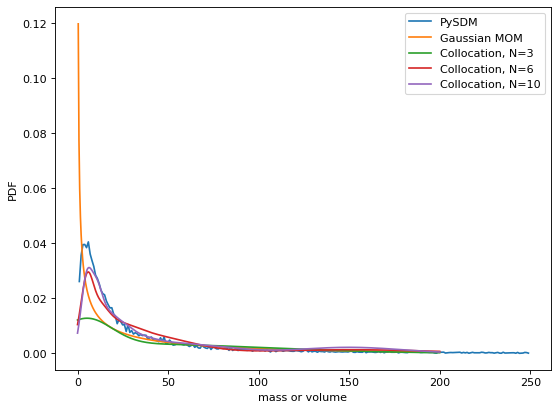

In [41]:
# plot all of them
pyplot.figure(num=None, figsize=(8,6), dpi=80, facecolor='w', edgecolor='k')

x = np.linspace(0,200,500)
x_sdm=v_bins_edges[:-1]
y_sdm=particles.products['N(v)'].get(v_bins_edges)/particles.products['Mk'].get(0)
pyplot.plot(x_sdm, y_sdm, label="PySDM")
#ykde = kde(x)
#pyplot.plot(x ,ykde, label="PySDM kde")
ymom = mom(x)
pyplot.plot(x, ymom, label="Gaussian MOM")
yrbf3 = rbf3(x)
pyplot.plot(x, yrbf3, label="Collocation, N=3")
yrbf6 = rbf6(x)
pyplot.plot(x, yrbf6, label="Collocation, N=6")
yrbf10 = rbf10(x)
pyplot.plot(x, yrbf10, label="Collocation, N=10")

pyplot.xlabel("mass or volume")
pyplot.ylabel("PDF")
pyplot.legend()

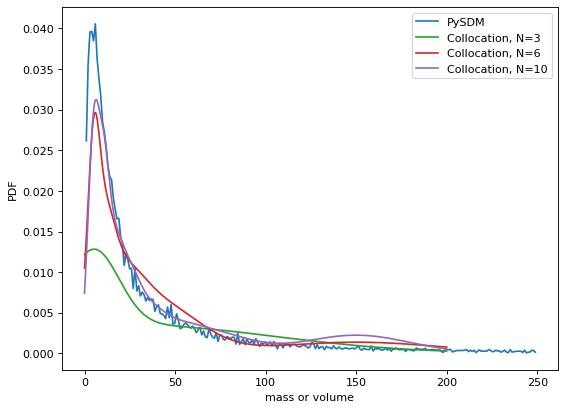

In [43]:
# plot all of them
pyplot.figure(num=None, figsize=(8,6), dpi=80, facecolor='w', edgecolor='k')

x = np.linspace(0,200,500)
x_sdm=v_bins_edges[:-1]
y_sdm=particles.products['N(v)'].get(v_bins_edges)/particles.products['Mk'].get(0)
pyplot.plot(x_sdm, y_sdm, label="PySDM")
#ykde = kde(x)
#pyplot.plot(x ,ykde, label="PySDM kde")
#ymom = mom(x)
#pyplot.plot(x, ymom, label="Gaussian MOM")
pyplot.plot(0,0)
yrbf3 = rbf3(x)
pyplot.plot(x, yrbf3, label="Collocation, N=3")
yrbf6 = rbf6(x)
pyplot.plot(x, yrbf6, label="Collocation, N=6")
yrbf10 = rbf10(x)
pyplot.plot(x, yrbf10, label="Collocation, N=10")

pyplot.xlabel("mass or volume")
pyplot.ylabel("PDF")
pyplot.legend()